In [1]:
import copy
import random
import re

import pandas
import numpy

from curve_fits import Call, Spec

from curve_fits import curves
from curve_fits import fits
from curve_fits import frames

In [2]:
def random_ints_sample(size, max_abs=10000):
    return random.sample(range(-max_abs, max_abs), k=size)

In [3]:
size_range = range(1050, 1750)
overfit = 1  # HIGH to differentiate from single-line shape
init_calls = [Call(random_ints_sample(size)) for size in size_range]
profile = frames.TimeComplexityProfile('set', init_calls, {'pop': Call(), 'copy': Call()},
    index=pandas.Index(size_range, name='List length'), overfit=overfit, fraction=0.9, loops=100)

In [4]:
profile.fit_all_with(
    Call(Spec(curves.Polynomial, 2), Spec(curves.Log, 1, pole=10), initial_params=[-1, 1, -1]),
    Call(Spec(curves.Xlog, 1), Spec(curves.InverseXPolynomial, 1)), piecewise=[
    Call([x], *[Call(Spec(curves.Polynomial, 2))]*2) for x in range(1300, 1420)])

In [5]:
profile.best_fits(limit=3)

kind  \
key  cost                                 
pop  0.008904  PW:Poly(1)-[1365]Poly(1)   
     0.009309  PW:Poly(1)-[1366]Poly(1)   
     0.009348  PW:Poly(1)-[1364]Poly(1)   
copy 0.011691  PW:Poly(1)-[1367]Poly(1)   
     0.012950  PW:Poly(1)-[1365]Poly(1)   
     0.013213  PW:Poly(1)-[1362]Poly(1)   

                                                             fit DOF  
key  cost                                                             
pop  0.008904  (-0.0072 ± 0.0021) + (0.0000506 ± 0.0000018)s ...   4  
     0.009309  (-0.0089 ± 0.0024) + (0.0000522 ± 0.0000020)s ...   4  
     0.009348  (-0.0078 ± 0.0022) + (0.0000512 ± 0.0000018)s ...   4  
copy 0.011691  (0.0034 ± 0.0030) + (0.0000655 ± 0.0000025)s |...   4  
     0.012950  (0.0065 ± 0.0027) + (0.0000628 ± 0.0000022)s |...   4  
     0.013213  (0.0068 ± 0.0027) + (0.0000626 ± 0.0000022)s |...   4

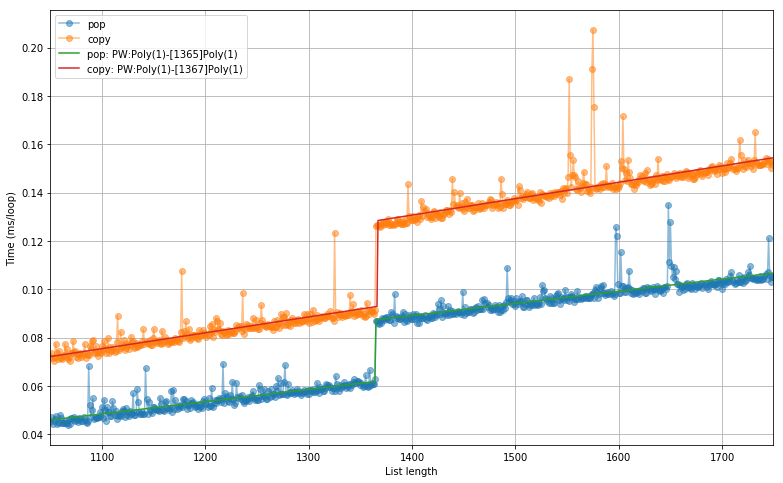

In [6]:
fig, ax = profile.plot(limit=1)

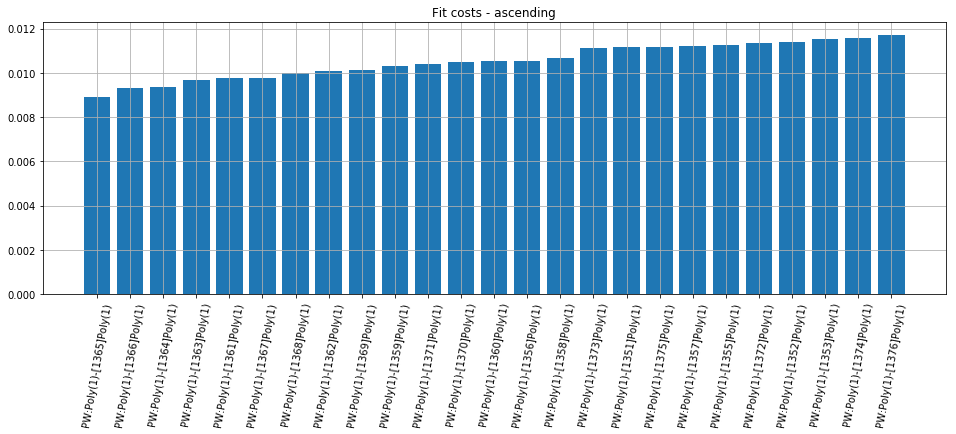

In [7]:
fig, ax = profile.plot_costs('pop', limit=25, rotation=80)

In [8]:
all_fits = profile.best_fits(limit=None)
all_fits[(all_fits.kind == 'Log+Poly(1)') | (all_fits.kind == 'Poly(-1)+Xlog')]

kind  \
key  cost                      
pop  0.019455  Poly(-1)+Xlog   
     0.019459    Log+Poly(1)   
copy 0.026996  Poly(-1)+Xlog   
     0.027676    Log+Poly(1)   

                                                             fit DOF  
key  cost                                                             
pop  0.019455   (0.000010325 ± 9.2E-8)s·log(s) + (-37.3 ± 1.3)/s   2  
     0.019459  (-0.80 ± 0.18) + (0.000018 ± 0.000021)s + (0.1...   3  
copy 0.026996    (0.00001447 ± 1.3E-7)s·log(s) + (-43.8 ± 1.8)/s   2  
     0.027676  (-1.07 ± 0.26) + (0.000028 ± 0.000031)s + (0.1...   3

In [9]:
pop_fit = profile.best_fit('pop')
pop_fit

<PiecewiseFit: (-0.0072 ± 0.0021) + (0.0000506 ± 0.0000018)s | (0.0189 ± 0.0029) + (0.0000502 ± 0.0000018)s>

In [10]:
pop_fit.fits, pop_fit.jumps_at

((<CurveFit: (-0.0072 ± 0.0021) + (0.0000506 ± 0.0000018)s>,
  <CurveFit: (0.0189 ± 0.0029) + (0.0000502 ± 0.0000018)s>),
 (1365,))

In [11]:
pop_fit.fits[1].measures

(<Measure: 0.0189 ± 0.0029>, <Measure: 0.0000502 ± 0.0000018>)

In [12]:
pop_fit_copy = copy.deepcopy(pop_fit)
pop_fit_copy.series = None   # Mocked to show equality is not affected
assert pop_fit == copy.deepcopy(pop_fit)

In [13]:
pop_fit_call = Call(pop_fit.jumps_at, *[Call(Spec(curves.Polynomial, 2))]*2)
assert pop_fit != fits.PiecewiseFit(profile.data['pop'], *pop_fit_call.args, **pop_fit_call.kwargs)

In [14]:
assert [re.sub(r'\[[0-9]{3,}\]', '', kind) for kind in profile.best_fits(limit=1)['kind']] == [
    'PW:Poly(1)-Poly(1)', 'PW:Poly(1)-Poly(1)']